## General purpose of this Notebook

The objetive of this notebook is to answer the following questions from article 1 selecting 6 different profiles of artisanal cheese producers and measure their respective efficiency using DEA analysis.

## Expected Results

The expected results is a general introduction of 5Sensu model, the presentation of DEA analysis and modification, a ranking of best producers efficiency 

## References

In [250]:
#https://stackoverflow.com/questions/44929118/minimizing-multi-objective-function-using-deap

## Folder

In [251]:
!ls

 animation_frames
 animation.html
 animation.ipynb
 canastra_completo.ipynb
 canastra.ipynb
 canastra_map.png
 canastra_network.pdf
 cpf.csv
 dea-canastra.ipynb
 deap-canastra.ipynb
 df_canastra.csv
 df_canastra_ph3.csv
 df_selected.csv
'Five sector sustainability Model a proposal for assessing sustainability of production systems(1).pdf'
 flow_graph.png
 genetic_graph.png
 model_s1.ipynb
 model_s2.ipynb
 multi_criteria_well.ods
 procedencia_canastra.pdf
 __pycache__
 pyDEA
 Questionario.pdf
'Questionário - Queijo Canastra VI - Final - Copia.pdf'
'Spreadsheet Mercosur.xlsm'
'The Impact of Geographical Indication on the Revitalisation of a Regional Economy: A Case.pdf'


## Data packages

In [252]:
#DATA ANALYSIS ENVELOPMENT PACKAGE

import os

os.chdir("/home/pauloyun/Documentos/model-canastra/pyDEA/pydea")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pulp
import dea as dea
import tools
import plot


In [253]:
##LAYOUT DISPOSITION

os.chdir("/home/pauloyun/Documentos/model-canastra")

import warnings

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

## Dataset retrieve

In [254]:
data = {
    'S_06_MUNICIPIO':["SÇO ROQUE DE MINAS","SÇO ROQUE DE MINAS","SÇO ROQUE DE MINAS","SÇO ROQUE DE MINAS","SÇO ROQUE DE MINAS","SÇO ROQUE DE MINAS"],
    'S_11_SEXO':["FEMININO","MASCULINO","MASCULINO","MASCULINO","MASCULINO","MASCULINO"],
    'S_13_NOME_PROPRIETARIO':["MARIA FATIMA","JOSE BORGES LEONEL FILHO","JOAQUIM DOMINGOS MADRUGA","JOSE DOMINGOS FERREIRA","ALAN CORREA FERREIRA","RENE GUALBERTO DE FARIA"],
    'S_15_IDADE':[71,42,49,61,35,56], #MARIO,IVAIR,ONESIO,TRADICIONAL ABANDADONA,CAPIM CANASTRA,ROÇA DA CIDADE
    'S_21_AREA_PROPRIEDADE':[31,40,78,100,110,130], #!
    
    'S_23_CASO_POSITIVO_QUANTOS_KVA':[1,1,2,2,2,3], #! OK
    
    'S_50_PRODUÇÃO_TOTAL_DE_LEITE_DIA':[100,100,100,100,431,1000], #!
    'S_74_2_PORCENTAGEM_NA_FABRICAÇÃO_DO_QUEIJO':[100,100,100,100,100,100],
    'S_78_2_PESO_TOTAL_DIA_QUEIJO_CANASTRA':[100,100,100,100,100,100],
    'S_67_NÚMERO_TOTAL_REBANHO_LEITEIRO':[11,24,31,34,105,51], #!
    'S_79_2_PREÇO_MÉDIO_RECEBIDO_QUEIJO_CANASTRA':[9,9,9,9,9,9],
    'S_129_QUAL_RENDA_TOTAL_MENSAL_FAMILIAR':[5000,5000,5000,5000,5000,5000],
    'S_95_HÁ_QUANTO_TEMPO_PRODUZ_QUEIJO':[50,12,20,22,4,21],
    'S_149_QUANTAS_PESSOAS_CONTRATADAS_TRABALHAM':[3,3,3,3,6,7], #!
    'S_148_NUMERO_FAMILIARES_TRABALHAM_PROPRIEDADE':[0,0,1,2,5,4] #!
}

In [255]:
select_df = pd.DataFrame.from_dict(data)

## New Variables/Features Creation 

In [256]:
import random
def random_float(low, high):
    return random.random()*(high-low) + low

def random_int(low, high):
    return random.randint(low,high)

In [257]:
# Soro de leite por dia

for i in tqdm(range(select_df.shape[0])):
    select_df.loc[i,"WHEY_DAY"] = select_df.loc[i,"S_50_PRODUÇÃO_TOTAL_DE_LEITE_DIA"] * random_float(0.7,0.9)
    
# CO por dia
    
for i in tqdm(range(select_df.shape[0])):
    select_df.loc[i,"CO_DAY"] = select_df.loc[i,"S_67_NÚMERO_TOTAL_REBANHO_LEITEIRO"]* random_int(75,85)

# WORKFORCE por dia    
    
select_df["TOTAL_WORKFORCE"]= select_df["S_149_QUANTAS_PESSOAS_CONTRATADAS_TRABALHAM"] + select_df["S_148_NUMERO_FAMILIARES_TRABALHAM_PROPRIEDADE"]

#CHEESE PRODUCTION using Proxy as Milk Dailly Litter

for i in tqdm(range(select_df.shape[0])):
    select_df.loc[i,"CHEESE_PROXY"] = (select_df.loc[i,"S_50_PRODUÇÃO_TOTAL_DE_LEITE_DIA"] * select_df.loc[i,"S_74_2_PORCENTAGEM_NA_FABRICAÇÃO_DO_QUEIJO"]/100)/random_int(7,9)

# DAILLY REVENUE 

select_df["REVENUE_DAY"]=select_df["S_79_2_PREÇO_MÉDIO_RECEBIDO_QUEIJO_CANASTRA"] * select_df["CHEESE_PROXY"]

# DAILLY TAX

dict_tax={0:0.1,
          1:0.15,
          2:0.2,
          3:0.25}

for i in tqdm(range(select_df.shape[0])):
    n=np.random.randint(0,4)
    select_df.loc[i,"TAX_DAY"] = select_df.loc[i,"REVENUE_DAY"]*dict_tax[n]
    
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
    
# select_df["S_95_HÁ_QUANTO_TEMPO_PRODUZ_QUEIJO"] = scaler.fit_transform(select_df["S_95_HÁ_QUANTO_TEMPO_PRODUZ_QUEIJO"].values.reshape(6,1))
# select_df["S_15_IDADE"] = scaler.fit_transform(select_df["S_15_IDADE"].values.reshape(6,1))


100%|██████████| 6/6 [00:00<00:00, 370.80it/s]


In [258]:
select_df

,S_06_MUNICIPIO,S_11_SEXO,S_13_NOME_PROPRIETARIO,S_15_IDADE,S_65_INFRAESTRUTURA_E_BENFEITORIAS_EXISTENTES,S_24_POSSUI_NUMERO_INSCRICAO_PRODUTOR,S_25_E_COOPERADO_SARONCRED,S_26_CASO_NAO_COOPERADO_MOTIVO,S_27_E_COOPERADO_A_APROCAN,S_28_CASO_NAO_ASSOCIADO_MOTIVO,S_55_POSSUI_IMPLANTADA_AS_BPF,S_134_FAZ_USO_CRÉDITO_RURAL,S_135_PARA_QUE_FAZ_USO_CRÉDITO_RURAL,S_136_FONTE_DE_RECURSO,S_137_MOTIVO_PARA_NÃO_USAR_CRÉDITO_RURAL,S_139_PROPRIEDADE_FAZ_CONTROLE_FINANCEIRO,S_140_COMO_FAZ_CONTROLE_FINANCEIRO,S_127_PODE_AFIRMAR_COM_CERTEZA_LUCRO_POR_UNIDADE_QUEIJO,S_141_PROPRIEDADE_FAZ_ALGUM_TIPO_PREVISAO,S_142_PROPRIEDADE_POSSUI_COMPUTADOR,S_143_A_PROPRIEDADE_POSSUI_INTERNET,S_93_POSSUI_IMPLANTADA_BPF,S_94_POSSUI_TREINAMENTO_EM_BPF,S_96_COM_QUEM_APRENDEU,S_131_APENAS_RENDA_QUEIJO_È_SUFICIENTE,S_21_AREA_PROPRIEDADE,S_23_CASO_POSITIVO_QUANTOS_KVA,S_50_PRODUÇÃO_TOTAL_DE_LEITE_DIA,S_74_2_PORCENTAGEM_NA_FABRICAÇÃO_DO_QUEIJO,S_78_2_PESO_TOTAL_DIA_QUEIJO_CANASTRA,S_67_NÚMERO_TOTAL_REBANHO_LEITEIRO,S_79_2_PREÇO_MÉDIO_RECEBIDO_QUEIJO_CANASTRA,S_129_QUAL_RENDA_TOTAL_MENSAL_FAMILIAR,S_95_HÁ_QUANTO_TEMPO_PRODUZ_QUEIJO,S_149_QUANTAS_PESSOAS_CONTRATADAS_TRABALHAM,S_148_NUMERO_FAMILIARES_TRABALHAM_PROPRIEDADE,WHEY_DAY,CO_DAY,TOTAL_WORKFORCE,CHEESE_PROXY,REVENUE_DAY,TAX_DAY
0,SÇO ROQUE DE MINAS,FEMININO,MARIA FATIMA,71,100,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,31,1,100,100,100,20,9,5000,50,3,0,71.796241,1560.0,3,12.500000,112.500000,16.875000
1,SÇO ROQUE DE MINAS,MASCULINO,JOSE BORGES LEONEL FILHO,42,100,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,40,1,100,100,100,24,9,5000,18,3,0,72.612962,1824.0,3,14.285714,128.571429,32.142857
2,SÇO ROQUE DE MINAS,MASCULINO,JOAQUIM DOMINGOS MADRUGA,49,100,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,78,2,100,100,100,31,9,5000,20,3,1,76.575840,2387.0,4,11.111111,100.000000,15.000000
3,SÇO ROQUE DE MINAS,MASCULINO,JOSE DOMINGOS FERREIRA,61,100,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,100,2,100,100,100,34,9,5000,22,3,2,72.841647,2618.0,5,14.285714,128.571429,25.714286
4,SÇO ROQUE DE MINAS,MASCULINO,ALAN CORREA FERREIRA,35,100,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,110,2,100,100,100,45,9,5000,4,6,4,85.008469,3645.0,10,11.111111,100.000000,25.000000
5,SÇO ROQUE DE MINAS,MASCULINO,RENE GUALBERTO DE FARIA,56,100,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,SIM,130,3,1000,100,100,70,9,5000,10,7,5,804.624353,5670.0,12,125.000000,1125.000000,225.000000


## Data Normalization (1 Ton of Cheese)

In [259]:
#Normalização

param_norm_div = ["S_21_AREA_PROPRIEDADE",
                "S_23_CASO_POSITIVO_QUANTOS_KVA",
                "S_67_NÚMERO_TOTAL_REBANHO_LEITEIRO",
                "TOTAL_WORKFORCE",
                  "WHEY_DAY",
                  "CO_DAY",
                  "REVENUE_DAY",
                  "TAX_DAY"
                  #,"S_95_HÁ_QUANTO_TEMPO_PRODUZ_QUEIJO",
                  #"S_15_IDADE"
                 ]

for i in tqdm(param_norm_div):
    select_df.loc[:,i+"{}".format("_NORM")] = round(select_df[i] / (1000/select_df["CHEESE_PROXY"]),2)

100%|██████████| 8/8 [00:00<00:00, 383.30it/s]


## K Variables  Selection and Goals 

In [260]:
#K1 
#S_21_AREA_PROPRIEDADE_NORM MAX - INPUT
#S_23_CASO_POSITIVO_QUANTOS_KVA_NORM MAX - INPUT

#K2
#WHEY_DAY_NORM - OUTPUT
#CO_DAY_NORM - OUPUT

#K3
#S_67_NÚMERO_TOTAL_REBANHO_LEITEIRO_NORM MAX - INPUT
#REVENUE_DAY_NORM MAX - OUTPUT

#K4
#TOTAL_WORKFORCE_NORM MAX - INPUT
#S_95_HÁ_QUANTO_TEMPO_PRODUZ_QUEIJO MAX - INPUT

#K5
#S_15_IDADE MIN - INPUT
#TAX_DAY_NORM MAX - OUTPUT

# Data Envelopment Analysis(DEA)

### Data input and output strategy

In [261]:
inputs = select_df[["S_21_AREA_PROPRIEDADE_NORM",
           "S_23_CASO_POSITIVO_QUANTOS_KVA_NORM",
           "S_67_NÚMERO_TOTAL_REBANHO_LEITEIRO_NORM",
           "TOTAL_WORKFORCE_NORM"]]
            #,"S_95_HÁ_QUANTO_TEMPO_PRODUZ_QUEIJO"]]


outputs = select_df[["WHEY_DAY_NORM",
                     "CO_DAY_NORM",
                     "REVENUE_DAY_NORM",
                     "TAX_DAY_NORM"]]
                     #,"S_15_IDADE"]]

## DEA Running Script

In [262]:
model_1 = dea.DEAProblem(inputs = inputs, outputs = outputs, returns='CRS')

In [263]:
model_1_results = model_1.solve()

## Data Envelopment Analysis Efficiency Results

In [264]:
model_1_results["Status"]

0    Optimal
1    Optimal
2    Optimal
3    Optimal
4    Optimal
5    Optimal
Name: Status, dtype: object

In [265]:
#Ranking
model_1_results['Efficiency']

0    1.000000
1    1.000000
2    1.000000
3    0.961216
4    1.000000
5    1.000000
Name: Efficiency, dtype: float64

In [266]:
#Beta Weights
model_1_results['Weights']

,in_S_21_AREA_PROPRIEDADE_NORM,in_S_23_CASO_POSITIVO_QUANTOS_KVA_NORM,in_S_67_NÚMERO_TOTAL_REBANHO_LEITEIRO_NORM,in_TOTAL_WORKFORCE_NORM,out_WHEY_DAY_NORM,out_CO_DAY_NORM,out_REVENUE_DAY_NORM,out_TAX_DAY_NORM
0,0.517751,0.000000,3.192308,0.000000,0.000000,0.051282,0.0,0.000000
1,1.518813,0.000000,0.000000,3.356910,0.000000,0.035524,0.0,0.161391
2,0.057818,0.000000,2.457029,2.857710,0.000000,0.037707,0.0,0.000000
3,0.000000,0.000000,1.836012,1.433631,0.000000,0.025701,0.0,0.000000
4,0.000000,6.033747,1.664950,0.425912,0.000000,0.024691,0.0,0.000000
5,0.000000,0.000000,0.114286,0.000000,0.009942,0.000000,0.0,0.000000


## Data Plotting

Text(0.5, 1.0, 'Distribution of efficiency scores')

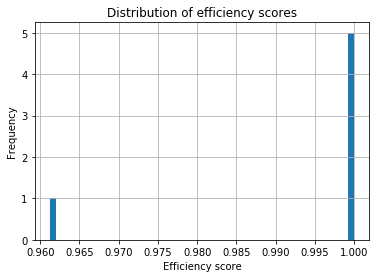

In [267]:
model_1_results['Efficiency'].hist(bins=50)
plt.ylabel('Frequency')
plt.xlabel('Efficiency score')
plt.title('Distribution of efficiency scores')

## Results 

In [268]:
#Ranking
model_1_results['Efficiency']

0    1.000000
1    1.000000
2    1.000000
3    0.961216
4    1.000000
5    1.000000
Name: Efficiency, dtype: float64